In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/alphaniroo/EURUSD-60-DS.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [ ]:
input_features = ['Open', 'High', 'Low', 'Close']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [ ]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 128
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [ ]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84671
تعداد نمونه‌های Validation: 10583
تعداد نمونه‌های Test: 10585


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# تعریف تابع ضرر FLF به صورت مستقل
def FLF(yTrue, yPred):
    lam = 0.1
    v = Lambda(lambda x: x * 0.9)((yTrue - yPred))
    vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2))
    vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 0] + yTrue[:, 3]) / 2 - (yPred[:, 0] + yPred[:, 3]) / 2))
    vx = K.square((v[:, 0] - vn1))
    vy = K.square((v[:, 1] - vn))
    vz = K.square((v[:, 2] - vn))
    v4 = K.square((v[:, 3] - vn1))
    vm = K.concatenate([vx, vy, vz, v4])
    vmx = K.mean(vm)
    return vmx

# ایجاد مدل LSTM بهینه‌شده
model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(90, len(input_features))),  # افزایش Sequence Length
    Dropout(0.2),  # افزایش Dropout
    BatchNormalization(),

    LSTM(100, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(50, return_sequences=False),
    Dropout(0.2),

    Dense(25, activation='relu'),  # اضافه کردن Dense با ReLU
    Dense(4)  # خروجی یک مقدار عددی
])

optimizer = Adam(learning_rate=0.005)

model.compile(optimizer=optimizer, loss=FLF, metrics=['mae','mse','mape'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 200)             │         164,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 200)             │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,179 (1.21 MB)

 Trainable params: 316,579 (1.21 MB)

 Non-trainable params: 600 (2.34 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stop])



Epoch 1/50
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - loss: 0.0059 - mae: 0.0550 - mape: 12.8746 - mse: 0.0079 - val_loss: 0.0043 - val_mae: 0.0590 - val_mape: 16120.7930 - val_mse: 0.0043
Epoch 2/50
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 59s 22ms/step - loss: 6.8163e-04 - mae: 0.0228 - mape: 5.8136 - mse: 8.8913e-04 - val_loss: 0.0061 - val_mae: 0.0721 - val_mape: 15551.9502 - val_mse: 0.0061
Epoch 3/50
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 4.2512e-04 - mae: 0.0179 - mape: 4.6187 - mse: 5.5397e-04 - val_loss: 0.0135 - val_mae: 0.1134 - val_mape: 17214.7090 - val_mse: 0.0135
Epoch 4/50
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - loss: 3.1640e-04 - mae: 0.0155 - mape: 4.0083 - mse: 4.1235e-04 - val_loss: 0.0019 - val_mae: 0.0366 - val_mape: 13048.1562 - val_mse: 0.0019
Epoch 5/50
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 2.7713e-04 - mae: 0.0142 - mape: 3.6406 - mse: 3.6115e-04 - val_loss: 0.0340 - val_mae: 0.1635 - val_mape: 15036.0527 - val_mse: 0.0340
Epoch 6

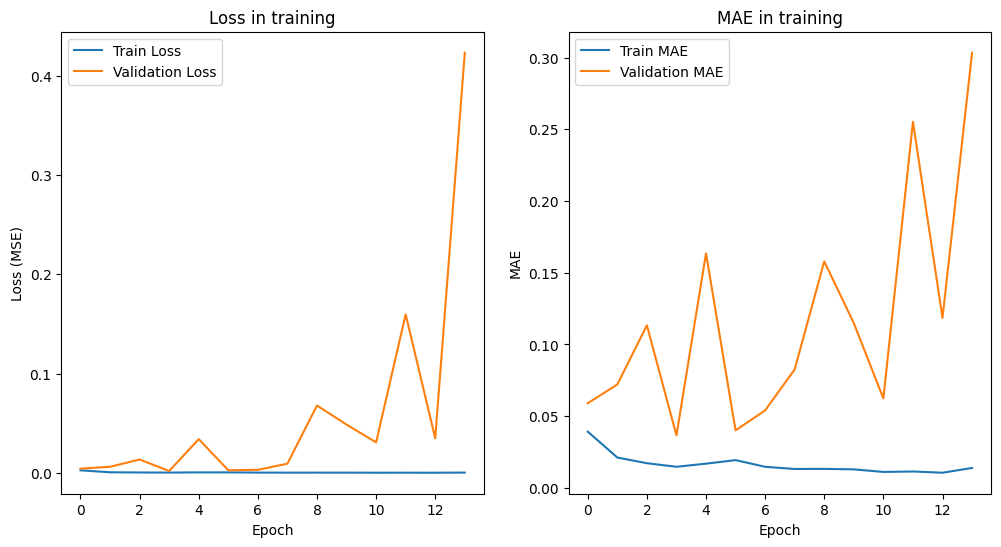

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

معیارهای ارزیابی برای Open:
MSE: 0.00033690032850070527
RMSE: 0.018354844823661825
MAE: 0.018157498838047178
R² Score: -0.1933196133865358

معیارهای ارزیابی برای High:
MSE: 0.0003459973755229938
RMSE: 0.01860100469122552
MAE: 0.01839816357097527
R² Score: -0.228778958745409

معیارهای ارزیابی برای Low:
MSE: 0.00033139626640077066
RMSE: 0.018204292526785286
MAE: 0.017992609041339223
R² Score: -0.17113104732160855

معیارهای ارزیابی برای Close:
MSE: 0.0003345778817211994
RMSE: 0.018291470190260797
MAE: 0.01807481586813803
R² Score: -0.18442974245738575

دقت جهت برای Close: 48.40325018896448%


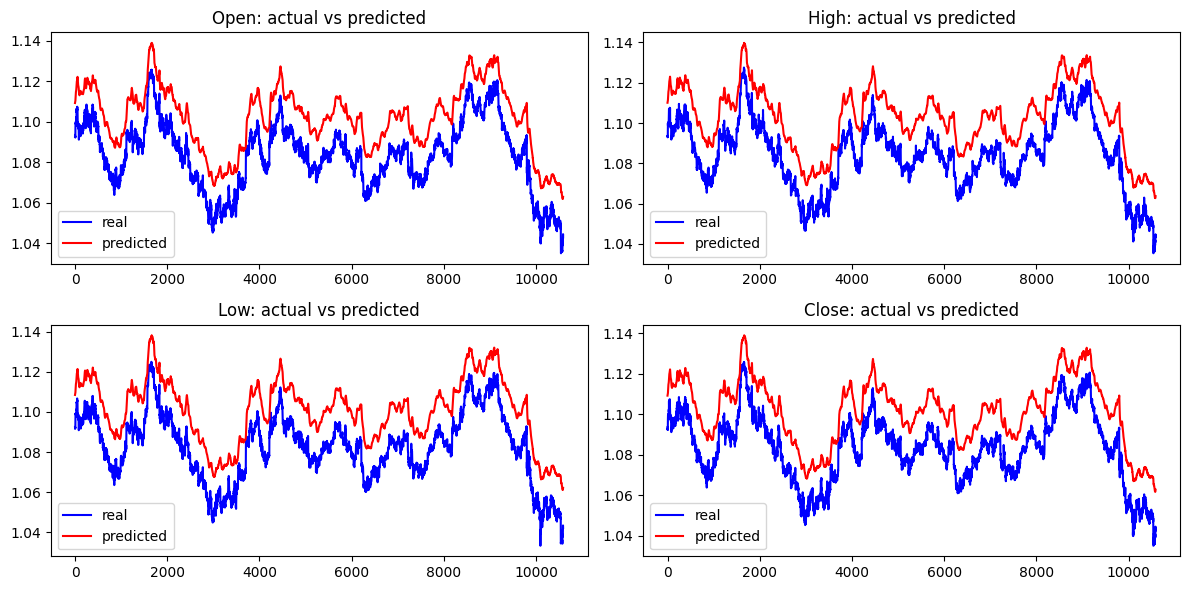

In [ ]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

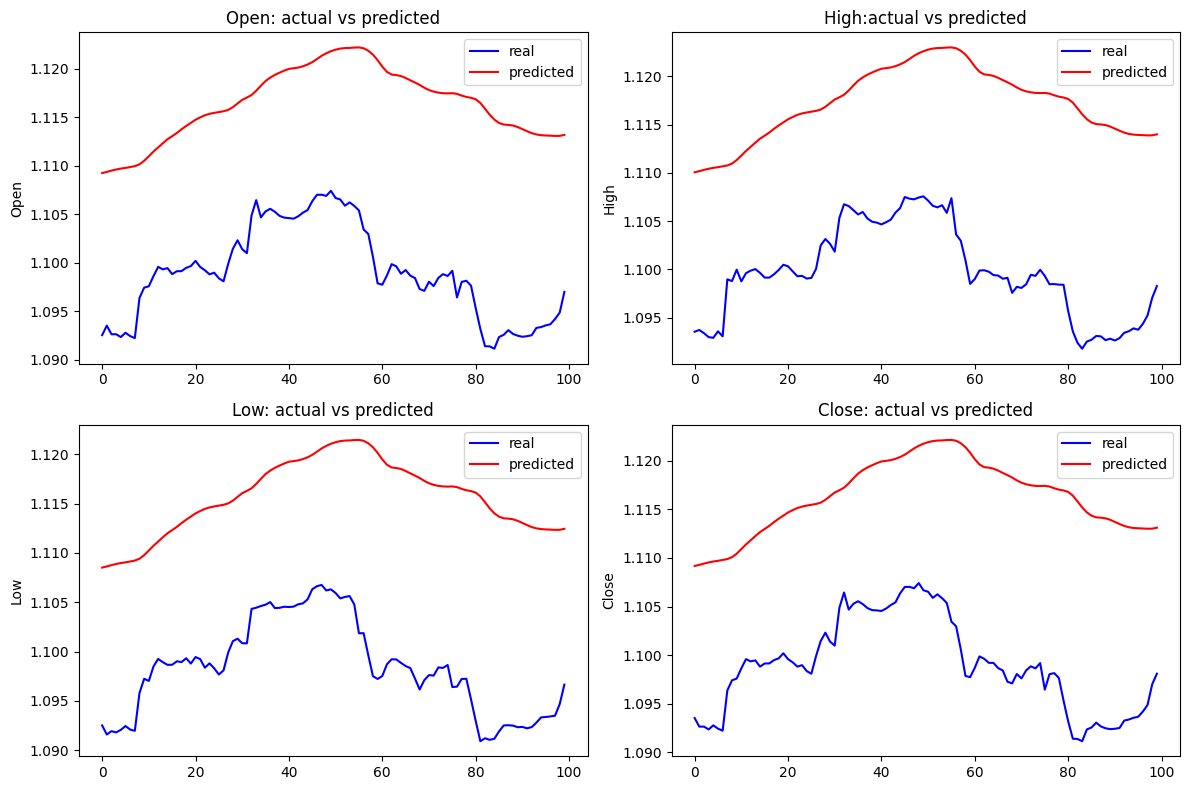

In [ ]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()

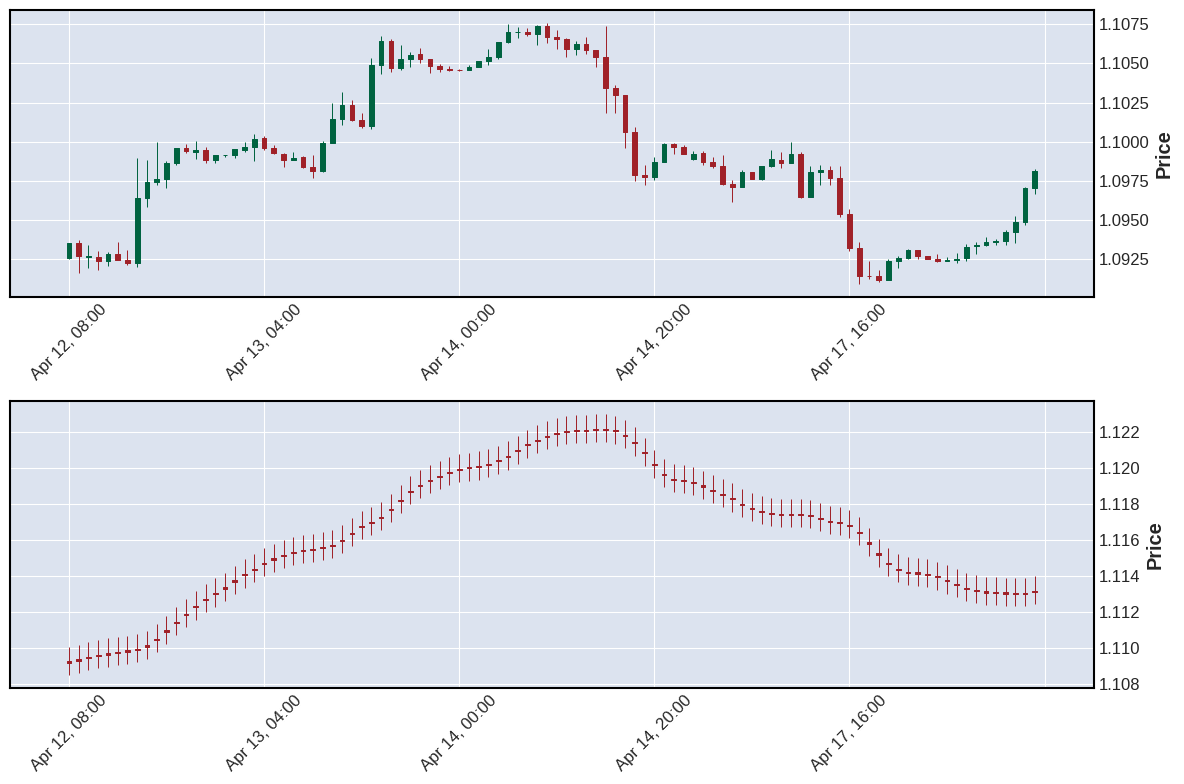

In [ ]:
import mplfinance as mpf
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

# رسم کندل‌ها با استفاده از mpf.make_subplots
# به جای plt.subplots، از خود mplfinance برای مدیریت زیرنمودارها استفاده می‌کنیم
fig = mpf.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# رسم کندل‌های واقعی و پیش‌بینی‌شده
mpf.plot(actual_candles, type='candle', style='charles', ax=ax1)
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax2)

# تنظیم فاصله بین زیرنمودارها
fig.tight_layout()
mpf.show()

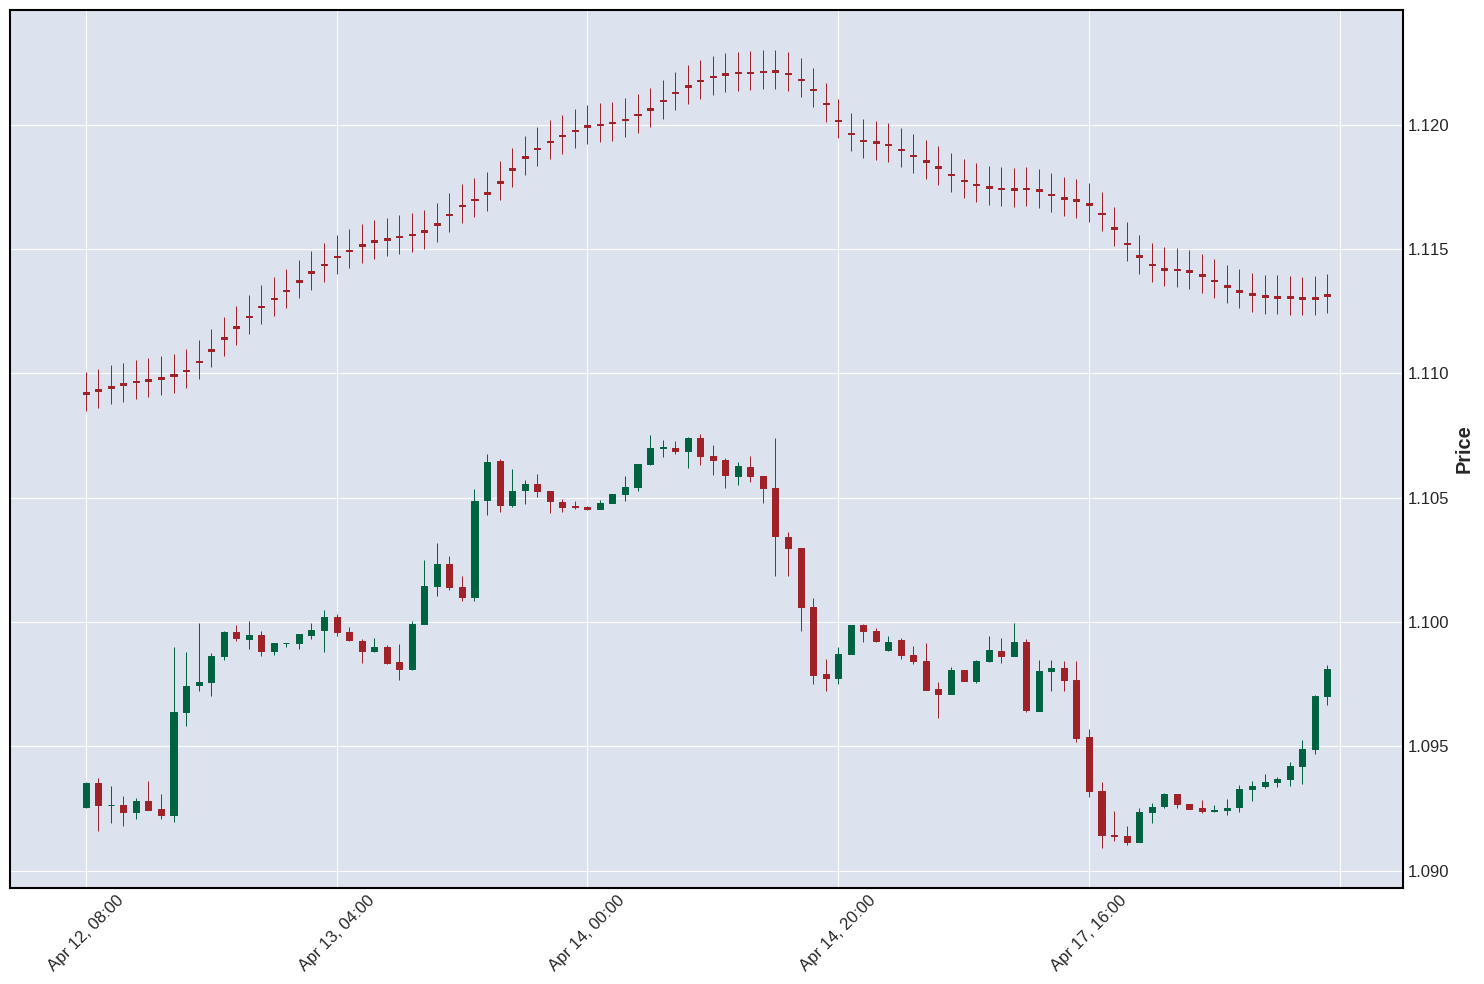

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

mpf.plot(actual_candles, type='candle', style='charles', ax=ax)


# کندل‌های پیش‌بینی‌شده (پررنگ) روی همون محور
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax)


# نمایش نمودار
fig.tight_layout()
mpf.show()